In [1]:
from data_loaders.AUS_dataset import AUSDataset, AUSPytorchDataset
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from project_settings import EOS_TOK, EOC_TOK
import pdb
from tqdm import tqdm, trange
import numpy as np
from models.Model import MeanModel, TruncatModel, NNModel
from project_settings import ExpConfig, DatasetConfig
from utils import chunkify, encode_chunks, transform_chunk_to_dict, parse_xml, load_file
from metrics import *

## Preparing the Data

In [2]:
from io import open
import glob
import os



def findFiles(path): return glob.glob(path)

# Read a file and split into lines
def readLines(filename):
    case_content = load_file(filename)
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    sentences = case_content["sentences"]
    catchphrases = case_content["catchphrases"]
    return sentences, catchphrases



In [3]:

# Build the case_lines dictionary, a list of names per language
case_sentences = {}
case_catchphrases = {}
idx_catchphrases={}
all_cases = []

ds_conf = DatasetConfig("AUS")
split="val"
item_to_n = load_file(
            os.path.join(ds_conf.processed_path, '{}/item-to-n.json'.format(split)))
idx = 0
idx_to_item = {}
for item, n_reviews in item_to_n.items():
    idx_to_item[idx] = item
    idx += 1

In [4]:
idx=0
for fn in idx_to_item.values():
    fp = os.path.join(ds_conf.processed_path, '{}/{}'.format(split, item))
    case_content = load_file(fp)
    case=fn
    all_cases.append(case)
    sentences = EOS_TOK.join(case_content["sentences"])
    catchphrases = case_content["catchphrases"]
    case_sentences[case] = sentences
    case_catchphrases[case]=[]
    for catchphrase in catchphrases:
        idx_catchphrases[idx]=catchphrase
        case_catchphrases[case].append(idx)
        idx+=1

In [5]:
len(all_cases),len(idx_catchphrases)

(350, 1750)

In validation split:
- **350** cases 
- **1750** catchphrases


We have 
- **case_sentences**, a dictionary mapping each case(id) to its text. 
- **case_catchphrases**, a dictionary mapping each case(id) to a list containing the catchphrases related( indices).
- **idx_catchphrases**, a dictionary mapping each id to the catchphrases. 
- **all_cases**  We also kept track of all_cases (just a list of case ids)

## Turning catchphrases into Tensors


Use BERT tiny:
- feature dimension: 128
- number of layer: 3


New data:
- **catchphrase_repr={}**,  a dictionary mapping each catchphrase(id) to its representaion in vector space
- **catchphrase_repr_norm**, a normalised version of catchphrase_repr, each vector is normalised to 1.

In [6]:
exp_config = ExpConfig("MeanModel")

In [7]:
tokenizer = AutoTokenizer.from_pretrained(exp_config.uri)
encoder = AutoModel.from_pretrained(exp_config.uri) 

In [8]:
encoder.eval

<bound method Module.eval of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

In [13]:
catchphrase_repr={}
for key,value in tqdm(idx_catchphrases.items()):
    text_idx = tokenizer(value, truncation=True, return_tensors="pt",
                                            padding='max_length', max_length=18)
    last_hidden_state, pooler_output = encoder(**text_idx)
    catchphrase_repr[key]=pooler_output


  6%|▌         | 101/1750 [00:04<01:18, 20.88it/s]


KeyboardInterrupt: 

In [9]:
catchphrase_repr[0].size()

NameError: name 'catchphrase_repr' is not defined

In [10]:
catchphrase_repr_norm= {k: F.normalize(v, p=2, dim=1) for k,v in catchphrase_repr.items() }

NameError: name 'catchphrase_repr' is not defined

## Construct the retrieval model

In [12]:
def cosine_sim(im, s):
    """Cosine similarity between all the image and sentence pairs
    """
    return im.mm(s.t())

Use **cosine similairty** as retrieval criterion

In [13]:
def predict(text, catchphrase_repr):
    """
    text: list of string or a string
    
    sim_tensor: of shape(N,num_catchphrases). N = num of input strings
    allocating a score for each catchphrases
    """
    text_idx = tokenizer(text, truncation=True, return_tensors="pt",
                                            padding='max_length', max_length=512)
    last_hidden_state, pooler_output = encoder(**text_idx)
    query = F.normalize(pooler_output, p=2, dim=1)
    catchphrase_repr_matrix=torch.cat(list(catchphrase_repr.values()),dim=0)
    sim_tensor = cosine_sim(query,catchphrase_repr_matrix)
#     top_v, top_i = sim_tensor.topk(k)
    return sim_tensor
    
    
    
    

In [14]:
y_pred=predict([case_sentences["06_102.xml"],case_sentences["06_102.xml"] ], catchphrase_repr_norm)

NameError: name 'catchphrase_repr_norm' is not defined

In [15]:
y_pred.shape

NameError: name 'y_pred' is not defined

## Evaluating the Results

In [16]:
len(catchphrase_repr_norm)

NameError: name 'catchphrase_repr_norm' is not defined

In [17]:
case_ids=['06_102.xml']

In [19]:
case_sents=[case_sentences[case_id] for case_id in case_ids]

In [20]:
y_pred=predict(case_sents, catchphrase_repr_norm).detach().numpy()

In [22]:
def one_hot(y_true, num_catchphrase):
    """
    convert y from discret representation to one hot representation.
    The metric functions require one hot representation
    """
    one_hot=[0]*num_catchphrase
    for idx in y_true:
        one_hot[idx]=1
    return one_hot

In [23]:

def evaluate(case_ids, catchphrase_repr_norm, case_sentences=case_sentences,
             case_catchphrases=case_catchphrases):
    """
    case_ids: list of case_id
    """
    case_sents=[case_sentences[case_id] for case_id in case_ids]
    y_pred=predict(case_sents, catchphrase_repr_norm).detach().numpy()
    NUM_CATCHPHRASES=len(catchphrase_repr_norm)
    
    y_true_s=[case_catchphrases[case_id] for case_id in case_ids]
    y_true=np.array([one_hot(y_true_,NUM_CATCHPHRASES ) for y_true_ in y_true_s])  # one hot form
    return y_true, y_pred
    

In [24]:
def metrics(y_true, y_pred):
    return mean_precision_k(y_true,y_pred), mean_recall_k(y_true,y_pred),mean_rprecision_k(y_true,y_pred),mean_ndcg_score_k(y_true,y_pred)



In [25]:
precision_k=[]
recall_k=[]
rprecision_k=[]
ndcg_score_k=[]

In [26]:
y_true, y_pred = evaluate(case_ids, catchphrase_repr_norm)

In [27]:
for case_id in tqdm(all_cases):
    case_ids=[case_id]
    print(case_ids)
    y_true, y_pred = evaluate(case_ids, catchphrase_repr_norm)
    mean_prec_k, mean_recal_k,mean_rprec_k,mean_ndcg__k=metrics(y_true, y_pred)
    precision_k.append(mean_prec_k)
    recall_k.append(mean_recal_k)
    rprecision_k.append(mean_rprec_k)
    ndcg_score_k.append(mean_ndcg__k)
    print(mean_prec_k, mean_recal_k,mean_rprec_k,mean_ndcg__k)

  0%|          | 0/350 [00:00<?, ?it/s]

['06_102.xml']


  0%|          | 1/350 [00:05<34:38,  5.95s/it]

0.0 0.0 0.0 0.0
['06_1041.xml']


  1%|          | 2/350 [00:10<32:19,  5.57s/it]

0.0 0.0 0.0 0.0
['06_1056.xml']


  1%|          | 3/350 [00:15<30:53,  5.34s/it]

0.0 0.0 0.0 0.0
['06_1078.xml']


  1%|          | 4/350 [00:19<29:21,  5.09s/it]

0.0 0.0 0.0 0.0
['06_1095.xml']


  1%|▏         | 5/350 [00:27<32:54,  5.72s/it]

0.0 0.0 0.0 0.0
['06_1113.xml']


  2%|▏         | 6/350 [00:31<30:19,  5.29s/it]

0.0 0.0 0.0 0.0
['06_1124.xml']


  2%|▏         | 7/350 [00:32<22:47,  3.99s/it]

0.0 0.0 0.0 0.0
['06_1163.xml']


  2%|▏         | 8/350 [00:33<17:42,  3.11s/it]

0.0 0.0 0.0 0.0
['06_1175.xml']


  3%|▎         | 9/350 [00:34<13:59,  2.46s/it]

0.0 0.0 0.0 0.0
['06_1193.xml']


  3%|▎         | 10/350 [00:35<11:26,  2.02s/it]

0.0 0.0 0.0 0.0
['06_1215.xml']


  3%|▎         | 11/350 [00:36<09:36,  1.70s/it]

0.0 0.0 0.0 0.0
['06_1235.xml']


  3%|▎         | 12/350 [00:37<08:18,  1.47s/it]

0.0 0.0 0.0 0.0
['06_125.xml']


  4%|▎         | 13/350 [00:38<07:28,  1.33s/it]

0.0 0.0 0.0 0.0
['06_1263.xml']


  4%|▍         | 14/350 [00:39<06:59,  1.25s/it]

0.0 0.0 0.0 0.0
['06_128.xml']


  4%|▍         | 15/350 [00:40<06:34,  1.18s/it]

0.0 0.0 0.0 0.0
['06_1293.xml']


  5%|▍         | 16/350 [00:41<06:08,  1.10s/it]

0.0 0.0 0.0 0.0
['06_1308.xml']


  5%|▍         | 17/350 [00:42<05:53,  1.06s/it]

0.0 0.0 0.0 0.0
['06_1326.xml']


  5%|▌         | 18/350 [00:43<05:38,  1.02s/it]

0.0 0.0 0.0 0.0
['06_1339.xml']


  5%|▌         | 19/350 [00:44<05:32,  1.01s/it]

0.0 0.0 0.0 0.0
['06_1355.xml']


  6%|▌         | 20/350 [00:45<05:33,  1.01s/it]

0.0 0.0 0.0 0.0
['06_1368.xml']


  6%|▌         | 21/350 [00:46<05:24,  1.02it/s]

0.0 0.0 0.0 0.0
['06_1380.xml']


  6%|▋         | 22/350 [00:47<05:18,  1.03it/s]

0.0 0.0 0.0 0.0
['06_1395.xml']


  7%|▋         | 23/350 [00:47<05:14,  1.04it/s]

0.0 0.0 0.0 0.0
['06_1403.xml']


  7%|▋         | 24/350 [00:48<05:06,  1.06it/s]

0.0 0.0 0.0 0.0
['06_1413.xml']


  7%|▋         | 25/350 [00:49<04:57,  1.09it/s]

0.0 0.0 0.0 0.0
['06_143.xml']


  7%|▋         | 26/350 [00:50<04:58,  1.09it/s]

0.1 0.2 0.2 0.21398626473452756
['06_1442.xml']


  8%|▊         | 27/350 [00:51<04:59,  1.08it/s]

0.0 0.0 0.0 0.0
['06_1457.xml']


  8%|▊         | 28/350 [00:52<05:01,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1475.xml']


  8%|▊         | 29/350 [00:53<05:02,  1.06it/s]

0.0 0.0 0.0 0.0
['06_1498.xml']


  9%|▊         | 30/350 [00:54<04:58,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1510.xml']


  9%|▉         | 31/350 [00:55<04:56,  1.08it/s]

0.0 0.0 0.0 0.0
['06_1532.xml']


  9%|▉         | 32/350 [00:56<04:56,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1544.xml']


  9%|▉         | 33/350 [00:57<04:56,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1557.xml']


 10%|▉         | 34/350 [00:58<04:53,  1.08it/s]

0.0 0.0 0.0 0.0
['06_1578.xml']


 10%|█         | 35/350 [00:59<04:50,  1.08it/s]

0.0 0.0 0.0 0.0
['06_1601.xml']


 10%|█         | 36/350 [00:59<04:50,  1.08it/s]

0.0 0.0 0.0 0.0
['06_162.xml']


 11%|█         | 37/350 [01:00<04:51,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1639.xml']


 11%|█         | 38/350 [01:01<04:52,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1655.xml']


 11%|█         | 39/350 [01:02<04:52,  1.06it/s]

0.0 0.0 0.0 0.0
['06_1683.xml']


 11%|█▏        | 40/350 [01:03<04:48,  1.07it/s]

0.0 0.0 0.0 0.0
['06_1702.xml']


 12%|█▏        | 41/350 [01:04<04:45,  1.08it/s]

0.0 0.0 0.0 0.0
['06_1716.xml']


 12%|█▏        | 42/350 [01:05<04:41,  1.09it/s]

0.0 0.0 0.0 0.0
['06_1735.xml']


 12%|█▏        | 43/350 [01:06<04:39,  1.10it/s]

0.0 0.0 0.0 0.0
['06_1759.xml']


 13%|█▎        | 44/350 [01:07<04:35,  1.11it/s]

0.0 0.0 0.0 0.0
['06_1778.xml']


 13%|█▎        | 45/350 [01:08<04:33,  1.11it/s]

0.1 0.2 0.2 0.11305340175787204
['06_1790.xml']


 13%|█▎        | 46/350 [01:09<04:30,  1.12it/s]

0.0 0.0 0.0 0.0
['06_1804.xml']


 13%|█▎        | 47/350 [01:09<04:31,  1.12it/s]

0.0 0.0 0.0 0.0
['06_1829.xml']


 14%|█▎        | 48/350 [01:10<04:37,  1.09it/s]

0.0 0.0 0.0 0.0
['06_196.xml']


 14%|█▍        | 49/350 [01:11<04:37,  1.09it/s]

0.0 0.0 0.0 0.0
['06_213.xml']


 14%|█▍        | 50/350 [01:12<04:36,  1.09it/s]

0.0 0.0 0.0 0.0
['06_230.xml']


 15%|█▍        | 51/350 [01:13<04:34,  1.09it/s]

0.0 0.0 0.0 0.0
['06_247.xml']


 15%|█▍        | 52/350 [01:14<04:32,  1.10it/s]

0.0 0.0 0.0 0.0
['06_264.xml']


 15%|█▌        | 53/350 [01:15<04:30,  1.10it/s]

0.0 0.0 0.0 0.0
['06_28.xml']


 15%|█▌        | 54/350 [01:16<04:27,  1.11it/s]

0.0 0.0 0.0 0.0
['06_307.xml']


 16%|█▌        | 55/350 [01:17<04:26,  1.11it/s]

0.0 0.0 0.0 0.0
['06_326.xml']


 16%|█▌        | 56/350 [01:18<04:23,  1.12it/s]

0.0 0.0 0.0 0.0
['06_341.xml']


 16%|█▋        | 57/350 [01:19<04:21,  1.12it/s]

0.0 0.0 0.0 0.0
['06_355.xml']


 17%|█▋        | 58/350 [01:19<04:21,  1.12it/s]

0.0 0.0 0.0 0.0
['06_37.xml']


 17%|█▋        | 59/350 [01:20<04:21,  1.11it/s]

0.0 0.0 0.0 0.0
['06_384.xml']


 17%|█▋        | 60/350 [01:21<04:19,  1.12it/s]

0.0 0.0 0.0 0.0
['06_395.xml']


 17%|█▋        | 61/350 [01:22<04:20,  1.11it/s]

0.0 0.0 0.0 0.0
['06_405.xml']


 18%|█▊        | 62/350 [01:23<04:22,  1.10it/s]

0.0 0.0 0.0 0.0
['06_42.xml']


 18%|█▊        | 63/350 [01:24<04:21,  1.10it/s]

0.0 0.0 0.0 0.0
['06_434.xml']


 18%|█▊        | 64/350 [01:25<04:19,  1.10it/s]

0.0 0.0 0.0 0.0
['06_446.xml']


 19%|█▊        | 65/350 [01:26<04:22,  1.09it/s]

0.0 0.0 0.0 0.0
['06_458.xml']


 19%|█▉        | 66/350 [01:27<04:27,  1.06it/s]

0.0 0.0 0.0 0.0
['06_475.xml']


 19%|█▉        | 67/350 [01:28<04:33,  1.03it/s]

0.0 0.0 0.0 0.0
['06_496.xml']


 19%|█▉        | 68/350 [01:29<04:37,  1.02it/s]

0.0 0.0 0.0 0.0
['06_508.xml']


 20%|█▉        | 69/350 [01:30<04:40,  1.00it/s]

0.0 0.0 0.0 0.0
['06_522.xml']


 20%|██        | 70/350 [01:31<04:38,  1.00it/s]

0.0 0.0 0.0 0.0
['06_546.xml']


 20%|██        | 71/350 [01:32<04:37,  1.00it/s]

0.0 0.0 0.0 0.0
['06_575.xml']


 21%|██        | 72/350 [01:33<04:39,  1.01s/it]

0.0 0.0 0.0 0.0
['06_592.xml']


 21%|██        | 73/350 [01:34<04:45,  1.03s/it]

0.0 0.0 0.0 0.0
['06_610.xml']


 21%|██        | 74/350 [01:35<04:44,  1.03s/it]

0.0 0.0 0.0 0.0
['06_626.xml']


 21%|██▏       | 75/350 [01:36<04:43,  1.03s/it]

0.0 0.0 0.0 0.0
['06_642.xml']


 22%|██▏       | 76/350 [01:37<04:43,  1.04s/it]

0.0 0.0 0.0 0.0
['06_653.xml']


 22%|██▏       | 77/350 [01:38<04:40,  1.03s/it]

0.0 0.0 0.0 0.0
['06_664.xml']


 22%|██▏       | 78/350 [01:39<04:39,  1.03s/it]

0.0 0.0 0.0 0.0
['06_682.xml']


 23%|██▎       | 79/350 [01:40<04:34,  1.01s/it]

0.0 0.0 0.0 0.0
['06_700.xml']


 23%|██▎       | 80/350 [01:41<04:27,  1.01it/s]

0.0 0.0 0.0 0.0
['06_710.xml']


 23%|██▎       | 81/350 [01:42<04:23,  1.02it/s]

0.0 0.0 0.0 0.0
['06_724.xml']


 23%|██▎       | 82/350 [01:43<04:21,  1.02it/s]

0.0 0.0 0.0 0.0
['06_736.xml']


 24%|██▎       | 83/350 [01:44<04:24,  1.01it/s]

0.0 0.0 0.0 0.0
['06_755.xml']


 24%|██▍       | 84/350 [01:45<04:23,  1.01it/s]

0.0 0.0 0.0 0.0
['06_768.xml']


 24%|██▍       | 85/350 [01:46<04:21,  1.01it/s]

0.0 0.0 0.0 0.0
['06_788.xml']


 25%|██▍       | 86/350 [01:47<04:21,  1.01it/s]

0.0 0.0 0.0 0.0
['06_809.xml']


 25%|██▍       | 87/350 [01:48<04:22,  1.00it/s]

0.1 0.2 0.2 0.10209739512291163
['06_821.xml']


 25%|██▌       | 88/350 [01:49<04:19,  1.01it/s]

0.0 0.0 0.0 0.0
['06_838.xml']


 25%|██▌       | 89/350 [01:50<04:20,  1.00it/s]

0.0 0.0 0.0 0.0
['06_85.xml']


 26%|██▌       | 90/350 [01:51<04:18,  1.00it/s]

0.0 0.0 0.0 0.0
['06_882.xml']


 26%|██▌       | 91/350 [01:52<04:20,  1.01s/it]

0.0 0.0 0.0 0.0
['06_892.xml']


 26%|██▋       | 92/350 [01:53<04:19,  1.01s/it]

0.0 0.0 0.0 0.0
['06_902.xml']


 27%|██▋       | 93/350 [01:54<04:17,  1.00s/it]

0.0 0.0 0.0 0.0
['06_92.xml']


 27%|██▋       | 94/350 [01:55<04:14,  1.01it/s]

0.0 0.0 0.0 0.0
['06_934.xml']


 27%|██▋       | 95/350 [01:56<04:11,  1.01it/s]

0.0 0.0 0.0 0.0
['06_946.xml']


 27%|██▋       | 96/350 [01:57<04:09,  1.02it/s]

0.0 0.0 0.0 0.0
['06_966.xml']


 28%|██▊       | 97/350 [01:58<04:08,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1.xml']


 28%|██▊       | 98/350 [01:59<04:06,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1011.xml']


 28%|██▊       | 99/350 [02:00<04:05,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1030.xml']


 29%|██▊       | 100/350 [02:01<04:03,  1.03it/s]

0.0 0.0 0.0 0.0
['07_105.xml']


 29%|██▉       | 101/350 [02:02<04:04,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1076.xml']


 29%|██▉       | 102/350 [02:03<04:05,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1091.xml']


 29%|██▉       | 103/350 [02:04<04:02,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1126.xml']


 30%|██▉       | 104/350 [02:05<04:01,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1159.xml']


 30%|███       | 105/350 [02:06<03:59,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1179.xml']


 30%|███       | 106/350 [02:07<03:58,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1197.xml']


 31%|███       | 107/350 [02:08<03:58,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1225.xml']


 31%|███       | 108/350 [02:09<03:58,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1249.xml']


 31%|███       | 109/350 [02:10<03:58,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1288.xml']


 31%|███▏      | 110/350 [02:11<03:55,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1327.xml']


 32%|███▏      | 111/350 [02:12<03:54,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1341.xml']


 32%|███▏      | 112/350 [02:13<03:53,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1358.xml']


 32%|███▏      | 113/350 [02:14<03:52,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1376.xml']


 33%|███▎      | 114/350 [02:15<03:50,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1389.xml']


 33%|███▎      | 115/350 [02:16<03:50,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1400.xml']


 33%|███▎      | 116/350 [02:17<03:51,  1.01it/s]

0.0 0.0 0.0 0.0
['07_142.xml']


 33%|███▎      | 117/350 [02:18<03:49,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1438.xml']


 34%|███▎      | 118/350 [02:19<03:47,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1465.xml']


 34%|███▍      | 119/350 [02:20<03:47,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1491.xml']


 34%|███▍      | 120/350 [02:21<03:45,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1507.xml']


 35%|███▍      | 121/350 [02:22<03:47,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1524.xml']


 35%|███▍      | 122/350 [02:23<03:44,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1539.xml']


 35%|███▌      | 123/350 [02:23<03:43,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1556.xml']


 35%|███▌      | 124/350 [02:24<03:41,  1.02it/s]

0.0 0.0 0.0 0.0
['07_157.xml']


 36%|███▌      | 125/350 [02:25<03:41,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1590.xml']


 36%|███▌      | 126/350 [02:27<03:46,  1.01s/it]

0.0 0.0 0.0 0.0
['07_1603.xml']


 36%|███▋      | 127/350 [02:28<03:48,  1.02s/it]

0.0 0.0 0.0 0.0
['07_1619.xml']


 37%|███▋      | 128/350 [02:29<03:49,  1.03s/it]

0.0 0.0 0.0 0.0
['07_165.xml']


 37%|███▋      | 129/350 [02:30<03:47,  1.03s/it]

0.0 0.0 0.0 0.0
['07_1663.xml']


 37%|███▋      | 130/350 [02:31<03:45,  1.03s/it]

0.0 0.0 0.0 0.0
['07_1690.xml']


 37%|███▋      | 131/350 [02:32<03:43,  1.02s/it]

0.0 0.0 0.0 0.0
['07_1707.xml']


 38%|███▊      | 132/350 [02:33<03:40,  1.01s/it]

0.0 0.0 0.0 0.0
['07_1725.xml']


 38%|███▊      | 133/350 [02:34<03:39,  1.01s/it]

0.0 0.0 0.0 0.0
['07_177.xml']


 38%|███▊      | 134/350 [02:35<03:38,  1.01s/it]

0.0 0.0 0.0 0.0
['07_1793.xml']


 39%|███▊      | 135/350 [02:36<03:36,  1.01s/it]

0.0 0.0 0.0 0.0
['07_182.xml']


 39%|███▉      | 136/350 [02:37<03:35,  1.00s/it]

0.0 0.0 0.0 0.0
['07_1844.xml']


 39%|███▉      | 137/350 [02:38<03:34,  1.01s/it]

0.0 0.0 0.0 0.0
['07_1865.xml']


 39%|███▉      | 138/350 [02:39<03:31,  1.00it/s]

0.0 0.0 0.0 0.0
['07_188.xml']


 40%|███▉      | 139/350 [02:40<03:31,  1.00s/it]

0.0 0.0 0.0 0.0
['07_1903.xml']


 40%|████      | 140/350 [02:41<03:29,  1.00it/s]

0.0 0.0 0.0 0.0
['07_1923.xml']


 40%|████      | 141/350 [02:42<03:28,  1.00it/s]

0.0 0.0 0.0 0.0
['07_1940.xml']


 41%|████      | 142/350 [02:43<03:26,  1.01it/s]

0.0 0.0 0.0 0.0
['07_1958.xml']


 41%|████      | 143/350 [02:44<03:23,  1.02it/s]

0.0 0.0 0.0 0.0
['07_1980.xml']


 41%|████      | 144/350 [02:45<03:23,  1.01it/s]

0.0 0.0 0.0 0.0
['07_2009.xml']


 41%|████▏     | 145/350 [02:46<03:23,  1.01it/s]

0.0 0.0 0.0 0.0
['07_2021.xml']


 42%|████▏     | 146/350 [02:47<03:22,  1.01it/s]

0.0 0.0 0.0 0.0
['07_2049.xml']


 42%|████▏     | 147/350 [02:48<03:23,  1.00s/it]

0.0 0.0 0.0 0.0
['07_2067.xml']


 42%|████▏     | 148/350 [02:49<03:24,  1.01s/it]

0.0 0.0 0.0 0.0
['07_2078.xml']


 43%|████▎     | 149/350 [02:50<03:24,  1.02s/it]

0.0 0.0 0.0 0.0
['07_2090.xml']


 43%|████▎     | 150/350 [02:51<03:23,  1.02s/it]

0.0 0.0 0.0 0.0
['07_2109.xml']


 43%|████▎     | 151/350 [02:52<03:24,  1.03s/it]

0.0 0.0 0.0 0.0
['07_224.xml']


 43%|████▎     | 152/350 [02:53<03:21,  1.02s/it]

0.0 0.0 0.0 0.0
['07_244.xml']


 44%|████▎     | 153/350 [02:54<03:23,  1.03s/it]

0.0 0.0 0.0 0.0
['07_257.xml']


 44%|████▍     | 154/350 [02:55<03:21,  1.03s/it]

0.0 0.0 0.0 0.0
['07_29.xml']


 44%|████▍     | 155/350 [02:56<03:17,  1.01s/it]

0.0 0.0 0.0 0.0
['07_309.xml']


 45%|████▍     | 156/350 [02:57<03:13,  1.00it/s]

0.0 0.0 0.0 0.0
['07_353.xml']


 45%|████▍     | 157/350 [02:58<03:13,  1.00s/it]

0.0 0.0 0.0 0.0
['07_382.xml']


 45%|████▌     | 158/350 [02:59<03:28,  1.08s/it]

0.0 0.0 0.0 0.0
['07_394.xml']


 45%|████▌     | 159/350 [03:00<03:22,  1.06s/it]

0.0 0.0 0.0 0.0
['07_410.xml']


 46%|████▌     | 160/350 [03:01<03:18,  1.04s/it]

0.0 0.0 0.0 0.0
['07_425.xml']


 46%|████▌     | 161/350 [03:02<03:15,  1.03s/it]

0.0 0.0 0.0 0.0
['07_439.xml']


 46%|████▋     | 162/350 [03:03<03:11,  1.02s/it]

0.0 0.0 0.0 0.0
['07_461.xml']


 47%|████▋     | 163/350 [03:04<03:10,  1.02s/it]

0.0 0.0 0.0 0.0
['07_479.xml']


 47%|████▋     | 164/350 [03:05<03:09,  1.02s/it]

0.0 0.0 0.0 0.0
['07_5.xml']


 47%|████▋     | 165/350 [03:06<03:07,  1.01s/it]

0.0 0.0 0.0 0.0
['07_512.xml']


 47%|████▋     | 166/350 [03:07<03:05,  1.01s/it]

0.0 0.0 0.0 0.0
['07_54.xml']


 48%|████▊     | 167/350 [03:08<03:02,  1.00it/s]

0.0 0.0 0.0 0.0
['07_56.xml']


 48%|████▊     | 168/350 [03:09<02:59,  1.01it/s]

0.0 0.0 0.0 0.0
['07_581.xml']


 48%|████▊     | 169/350 [03:10<02:58,  1.02it/s]

0.0 0.0 0.0 0.0
['07_599.xml']


 49%|████▊     | 170/350 [03:11<02:57,  1.01it/s]

0.0 0.0 0.0 0.0
['07_622.xml']


 49%|████▉     | 171/350 [03:12<02:55,  1.02it/s]

0.0 0.0 0.0 0.0
['07_648.xml']


 49%|████▉     | 172/350 [03:13<02:53,  1.03it/s]

0.0 0.0 0.0 0.0
['07_683.xml']


 49%|████▉     | 173/350 [03:14<02:51,  1.03it/s]

0.0 0.0 0.0 0.0
['07_714.xml']


 50%|████▉     | 174/350 [03:15<02:52,  1.02it/s]

0.0 0.0 0.0 0.0
['07_767.xml']


 50%|█████     | 175/350 [03:16<02:52,  1.02it/s]

0.0 0.0 0.0 0.0
['07_79.xml']


 50%|█████     | 176/350 [03:17<02:50,  1.02it/s]

0.0 0.0 0.0 0.0
['07_816.xml']


 51%|█████     | 177/350 [03:18<02:49,  1.02it/s]

0.1 0.2 0.2 0.09803928583135704
['07_831.xml']


 51%|█████     | 178/350 [03:19<02:47,  1.02it/s]

0.1 0.2 0.2 0.13120507751234178
['07_857.xml']


 51%|█████     | 179/350 [03:20<02:46,  1.03it/s]

0.1 0.2 0.2 0.16958010263680806
['07_875.xml']


 51%|█████▏    | 180/350 [03:21<02:44,  1.03it/s]

0.0 0.0 0.0 0.0
['07_898.xml']


 52%|█████▏    | 181/350 [03:22<02:44,  1.03it/s]

0.0 0.0 0.0 0.0
['07_914.xml']


 52%|█████▏    | 182/350 [03:23<02:44,  1.02it/s]

0.0 0.0 0.0 0.0
['07_925.xml']


 52%|█████▏    | 183/350 [03:24<02:44,  1.01it/s]

0.0 0.0 0.0 0.0
['07_94.xml']


 53%|█████▎    | 184/350 [03:25<02:43,  1.01it/s]

0.0 0.0 0.0 0.0
['07_961.xml']


 53%|█████▎    | 185/350 [03:26<02:42,  1.01it/s]

0.0 0.0 0.0 0.0
['07_978.xml']


 53%|█████▎    | 186/350 [03:27<02:42,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1004.xml']


 53%|█████▎    | 187/350 [03:28<02:42,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1021.xml']


 54%|█████▎    | 188/350 [03:29<02:42,  1.00s/it]

0.0 0.0 0.0 0.0
['08_1033.xml']


 54%|█████▍    | 189/350 [03:30<02:40,  1.00it/s]

0.0 0.0 0.0 0.0
['08_1056.xml']


 54%|█████▍    | 190/350 [03:31<02:39,  1.00it/s]

0.0 0.0 0.0 0.0
['08_1079.xml']


 55%|█████▍    | 191/350 [03:32<02:37,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1103.xml']


 55%|█████▍    | 192/350 [03:33<02:34,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1126.xml']


 55%|█████▌    | 193/350 [03:34<02:35,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1173.xml']


 55%|█████▌    | 194/350 [03:35<02:36,  1.00s/it]

0.0 0.0 0.0 0.0
['08_1219.xml']


 56%|█████▌    | 195/350 [03:36<02:37,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1248.xml']


 56%|█████▌    | 196/350 [03:37<02:34,  1.00s/it]

0.0 0.0 0.0 0.0
['08_1267.xml']


 56%|█████▋    | 197/350 [03:38<02:31,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1293.xml']


 57%|█████▋    | 198/350 [03:39<02:28,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1310.xml']


 57%|█████▋    | 199/350 [03:40<02:28,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1334.xml']


 57%|█████▋    | 200/350 [03:41<02:29,  1.00it/s]

0.0 0.0 0.0 0.0
['08_136.xml']


 57%|█████▋    | 201/350 [03:42<02:29,  1.00s/it]

0.0 0.0 0.0 0.0
['08_1388.xml']


 58%|█████▊    | 202/350 [03:43<02:29,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1405.xml']


 58%|█████▊    | 203/350 [03:44<02:28,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1426.xml']


 58%|█████▊    | 204/350 [03:45<02:27,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1453.xml']


 59%|█████▊    | 205/350 [03:46<02:26,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1469.xml']


 59%|█████▉    | 206/350 [03:47<02:25,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1485.xml']


 59%|█████▉    | 207/350 [03:48<02:23,  1.01s/it]

0.0 0.0 0.0 0.0
['08_15.xml']


 59%|█████▉    | 208/350 [03:49<02:24,  1.02s/it]

0.0 0.0 0.0 0.0
['08_1516.xml']


 60%|█████▉    | 209/350 [03:50<02:22,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1530.xml']


 60%|██████    | 210/350 [03:51<02:21,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1544.xml']


 60%|██████    | 211/350 [03:52<02:20,  1.01s/it]

0.0 0.0 0.0 0.0
['08_1572.xml']


 61%|██████    | 212/350 [03:53<02:17,  1.00it/s]

0.0 0.0 0.0 0.0
['08_1589.xml']


 61%|██████    | 213/350 [03:54<02:15,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1607.xml']


 61%|██████    | 214/350 [03:55<02:14,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1627.xml']


 61%|██████▏   | 215/350 [03:56<02:13,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1653.xml']


 62%|██████▏   | 216/350 [03:57<02:12,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1676.xml']


 62%|██████▏   | 217/350 [03:58<02:11,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1704.xml']


 62%|██████▏   | 218/350 [03:59<02:10,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1737.xml']


 63%|██████▎   | 219/350 [04:00<02:09,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1765.xml']


 63%|██████▎   | 220/350 [04:01<02:08,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1784.xml']


 63%|██████▎   | 221/350 [04:02<02:06,  1.02it/s]

0.1 0.2 0.2 0.14606834984270645
['08_1800.xml']


 63%|██████▎   | 222/350 [04:03<02:05,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1836.xml']


 64%|██████▎   | 223/350 [04:04<02:04,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1860.xml']


 64%|██████▍   | 224/350 [04:05<02:04,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1877.xml']


 64%|██████▍   | 225/350 [04:06<02:02,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1895.xml']


 65%|██████▍   | 226/350 [04:07<02:01,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1911.xml']


 65%|██████▍   | 227/350 [04:07<02:00,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1930.xml']


 65%|██████▌   | 228/350 [04:08<02:00,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1952.xml']


 65%|██████▌   | 229/350 [04:09<01:59,  1.01it/s]

0.0 0.0 0.0 0.0
['08_1973.xml']


 66%|██████▌   | 230/350 [04:10<01:58,  1.02it/s]

0.0 0.0 0.0 0.0
['08_1986.xml']


 66%|██████▌   | 231/350 [04:11<01:57,  1.01it/s]

0.0 0.0 0.0 0.0
['08_210.xml']


 66%|██████▋   | 232/350 [04:12<01:57,  1.00it/s]

0.0 0.0 0.0 0.0
['08_23.xml']


 67%|██████▋   | 233/350 [04:13<01:56,  1.01it/s]

0.0 0.0 0.0 0.0
['08_249.xml']


 67%|██████▋   | 234/350 [04:14<01:54,  1.01it/s]

0.0 0.0 0.0 0.0
['08_265.xml']


 67%|██████▋   | 235/350 [04:15<01:53,  1.01it/s]

0.0 0.0 0.0 0.0
['08_297.xml']


 67%|██████▋   | 236/350 [04:16<01:53,  1.01it/s]

0.0 0.0 0.0 0.0
['08_313.xml']


 68%|██████▊   | 237/350 [04:17<01:53,  1.01s/it]

0.0 0.0 0.0 0.0
['08_332.xml']


 68%|██████▊   | 238/350 [04:18<01:52,  1.01s/it]

0.0 0.0 0.0 0.0
['08_354.xml']


 68%|██████▊   | 239/350 [04:19<01:52,  1.01s/it]

0.0 0.0 0.0 0.0
['08_371.xml']


 69%|██████▊   | 240/350 [04:20<01:50,  1.01s/it]

0.0 0.0 0.0 0.0
['08_388.xml']


 69%|██████▉   | 241/350 [04:21<01:48,  1.00it/s]

0.0 0.0 0.0 0.0
['08_397.xml']


 69%|██████▉   | 242/350 [04:22<01:47,  1.00it/s]

0.0 0.0 0.0 0.0
['08_415.xml']


 69%|██████▉   | 243/350 [04:23<01:45,  1.01it/s]

0.1 0.2 0.2 0.3391602052736161
['08_429.xml']


 70%|██████▉   | 244/350 [04:24<01:46,  1.00s/it]

0.0 0.0 0.0 0.0
['08_444.xml']


 70%|███████   | 245/350 [04:26<01:47,  1.02s/it]

0.0 0.0 0.0 0.0
['08_457.xml']


 70%|███████   | 246/350 [04:27<01:48,  1.04s/it]

0.0 0.0 0.0 0.0
['08_47.xml']


 71%|███████   | 247/350 [04:28<01:47,  1.04s/it]

0.0 0.0 0.0 0.0
['08_489.xml']


 71%|███████   | 248/350 [04:29<01:46,  1.04s/it]

0.0 0.0 0.0 0.0
['08_502.xml']


 71%|███████   | 249/350 [04:30<01:43,  1.03s/it]

0.0 0.0 0.0 0.0
['08_519.xml']


 71%|███████▏  | 250/350 [04:31<01:42,  1.02s/it]

0.0 0.0 0.0 0.0
['08_531.xml']


 72%|███████▏  | 251/350 [04:32<01:40,  1.01s/it]

0.0 0.0 0.0 0.0
['08_549.xml']


 72%|███████▏  | 252/350 [04:33<01:40,  1.03s/it]

0.0 0.0 0.0 0.0
['08_562.xml']


 72%|███████▏  | 253/350 [04:34<01:39,  1.03s/it]

0.0 0.0 0.0 0.0
['08_575.xml']


 73%|███████▎  | 254/350 [04:35<01:39,  1.03s/it]

0.0 0.0 0.0 0.0
['08_588.xml']


 73%|███████▎  | 255/350 [04:36<01:37,  1.02s/it]

0.0 0.0 0.0 0.0
['08_60.xml']


 73%|███████▎  | 256/350 [04:37<01:35,  1.01s/it]

0.0 0.0 0.0 0.0
['08_613.xml']


 73%|███████▎  | 257/350 [04:38<01:33,  1.01s/it]

0.0 0.0 0.0 0.0
['08_634.xml']


 74%|███████▎  | 258/350 [04:39<01:32,  1.00s/it]

0.0 0.0 0.0 0.0
['08_66.xml']


 74%|███████▍  | 259/350 [04:40<01:31,  1.00s/it]

0.0 0.0 0.0 0.0
['08_691.xml']


 74%|███████▍  | 260/350 [04:41<01:31,  1.01s/it]

0.0 0.0 0.0 0.0
['08_711.xml']


 75%|███████▍  | 261/350 [04:42<01:29,  1.01s/it]

0.1 0.2 0.2 0.10699313236726378
['08_734.xml']


 75%|███████▍  | 262/350 [04:43<01:28,  1.00s/it]

0.0 0.0 0.0 0.0
['08_758.xml']


 75%|███████▌  | 263/350 [04:44<01:26,  1.01it/s]

0.0 0.0 0.0 0.0
['08_782.xml']


 75%|███████▌  | 264/350 [04:45<01:25,  1.01it/s]

0.0 0.0 0.0 0.0
['08_812.xml']


 76%|███████▌  | 265/350 [04:46<01:24,  1.01it/s]

0.0 0.0 0.0 0.0
['08_840.xml']


 76%|███████▌  | 266/350 [04:47<01:23,  1.00it/s]

0.0 0.0 0.0 0.0
['08_867.xml']


 76%|███████▋  | 267/350 [04:48<01:22,  1.00it/s]

0.0 0.0 0.0 0.0
['08_896.xml']


 77%|███████▋  | 268/350 [04:49<01:22,  1.00s/it]

0.0 0.0 0.0 0.0
['08_911.xml']


 77%|███████▋  | 269/350 [04:50<01:20,  1.01it/s]

0.0 0.0 0.0 0.0
['08_932.xml']


 77%|███████▋  | 270/350 [04:51<01:19,  1.01it/s]

0.0 0.0 0.0 0.0
['08_960.xml']


 77%|███████▋  | 271/350 [04:52<01:19,  1.00s/it]

0.0 0.0 0.0 0.0
['08_975.xml']


 78%|███████▊  | 272/350 [04:53<01:18,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1002.xml']


 78%|███████▊  | 273/350 [04:54<01:17,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1024.xml']


 78%|███████▊  | 274/350 [04:55<01:16,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1047.xml']


 79%|███████▊  | 275/350 [04:56<01:15,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1059.xml']


 79%|███████▉  | 276/350 [04:57<01:14,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1086.xml']


 79%|███████▉  | 277/350 [04:58<01:12,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1098.xml']


 79%|███████▉  | 278/350 [04:59<01:11,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1122.xml']


 80%|███████▉  | 279/350 [05:00<01:11,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1134.xml']


 80%|████████  | 280/350 [05:01<01:10,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1158.xml']


 80%|████████  | 281/350 [05:02<01:09,  1.01s/it]

0.0 0.0 0.0 0.0
['09_1175.xml']


 81%|████████  | 282/350 [05:03<01:07,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1194.xml']


 81%|████████  | 283/350 [05:04<01:06,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1208.xml']


 81%|████████  | 284/350 [05:05<01:05,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1217.xml']


 81%|████████▏ | 285/350 [05:06<01:04,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1235.xml']


 82%|████████▏ | 286/350 [05:07<01:04,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1255.xml']


 82%|████████▏ | 287/350 [05:08<01:03,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1272.xml']


 82%|████████▏ | 288/350 [05:09<01:02,  1.01s/it]

0.0 0.0 0.0 0.0
['09_129.xml']


 83%|████████▎ | 289/350 [05:10<01:01,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1305.xml']


 83%|████████▎ | 290/350 [05:11<00:59,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1328.xml']


 83%|████████▎ | 291/350 [05:12<00:58,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1362.xml']


 83%|████████▎ | 292/350 [05:13<00:57,  1.02it/s]

0.0 0.0 0.0 0.0
['09_1384.xml']


 84%|████████▎ | 293/350 [05:14<00:56,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1403.xml']


 84%|████████▍ | 294/350 [05:15<00:55,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1422.xml']


 84%|████████▍ | 295/350 [05:16<00:55,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1433.xml']


 85%|████████▍ | 296/350 [05:17<00:54,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1459.xml']


 85%|████████▍ | 297/350 [05:18<00:53,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1479.xml']


 85%|████████▌ | 298/350 [05:19<00:52,  1.00s/it]

0.1 0.2 0.2 0.1208113026994942
['09_1494.xml']


 85%|████████▌ | 299/350 [05:20<00:51,  1.00s/it]

0.0 0.0 0.0 0.0
['09_1514.xml']


 86%|████████▌ | 300/350 [05:21<00:49,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1533.xml']


 86%|████████▌ | 301/350 [05:22<00:48,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1559.xml']


 86%|████████▋ | 302/350 [05:23<00:47,  1.01it/s]

0.0 0.0 0.0 0.0
['09_1575.xml']


 87%|████████▋ | 303/350 [05:24<00:46,  1.00it/s]

0.0 0.0 0.0 0.0
['09_1597.xml']


 87%|████████▋ | 304/350 [05:25<00:45,  1.00it/s]

0.0 0.0 0.0 0.0
['09_170.xml']


 87%|████████▋ | 305/350 [05:26<00:45,  1.00s/it]

0.0 0.0 0.0 0.0
['09_192.xml']


 87%|████████▋ | 306/350 [05:27<00:44,  1.01s/it]

0.0 0.0 0.0 0.0
['09_209.xml']


 88%|████████▊ | 307/350 [05:28<00:43,  1.01s/it]

0.0 0.0 0.0 0.0
['09_227.xml']


 88%|████████▊ | 308/350 [05:29<00:42,  1.01s/it]

0.0 0.0 0.0 0.0
['09_243.xml']


 88%|████████▊ | 309/350 [05:30<00:41,  1.01s/it]

0.0 0.0 0.0 0.0
['09_253.xml']


 89%|████████▊ | 310/350 [05:31<00:40,  1.01s/it]

0.0 0.0 0.0 0.0
['09_266.xml']


 89%|████████▉ | 311/350 [05:32<00:38,  1.01it/s]

0.0 0.0 0.0 0.0
['09_283.xml']


 89%|████████▉ | 312/350 [05:33<00:37,  1.02it/s]

0.0 0.0 0.0 0.0
['09_306.xml']


 89%|████████▉ | 313/350 [05:34<00:37,  1.01s/it]

0.0 0.0 0.0 0.0
['09_321.xml']


 90%|████████▉ | 314/350 [05:35<00:36,  1.02s/it]

0.0 0.0 0.0 0.0
['09_339.xml']


 90%|█████████ | 315/350 [05:36<00:36,  1.03s/it]

0.0 0.0 0.0 0.0
['09_362.xml']


 90%|█████████ | 316/350 [05:37<00:34,  1.02s/it]

0.0 0.0 0.0 0.0
['09_388.xml']


 91%|█████████ | 317/350 [05:38<00:33,  1.01s/it]

0.0 0.0 0.0 0.0
['09_403.xml']


 91%|█████████ | 318/350 [05:39<00:32,  1.00s/it]

0.0 0.0 0.0 0.0
['09_43.xml']


 91%|█████████ | 319/350 [05:40<00:30,  1.01it/s]

0.0 0.0 0.0 0.0
['09_452.xml']


 91%|█████████▏| 320/350 [05:41<00:29,  1.01it/s]

0.0 0.0 0.0 0.0
['09_479.xml']


 92%|█████████▏| 321/350 [05:42<00:28,  1.00it/s]

0.0 0.0 0.0 0.0
['09_496.xml']


 92%|█████████▏| 322/350 [05:43<00:28,  1.01s/it]

0.0 0.0 0.0 0.0
['09_515.xml']


 92%|█████████▏| 323/350 [05:44<00:27,  1.01s/it]

0.0 0.0 0.0 0.0
['09_533.xml']


 93%|█████████▎| 324/350 [05:45<00:26,  1.01s/it]

0.0 0.0 0.0 0.0
['09_546.xml']


 93%|█████████▎| 325/350 [05:46<00:25,  1.01s/it]

0.0 0.0 0.0 0.0
['09_558.xml']


 93%|█████████▎| 326/350 [05:47<00:24,  1.01s/it]

0.0 0.0 0.0 0.0
['09_570.xml']


 93%|█████████▎| 327/350 [05:48<00:22,  1.00it/s]

0.0 0.0 0.0 0.0
['09_590.xml']


 94%|█████████▎| 328/350 [05:49<00:21,  1.00it/s]

0.0 0.0 0.0 0.0
['09_606.xml']


 94%|█████████▍| 329/350 [05:50<00:20,  1.00it/s]

0.0 0.0 0.0 0.0
['09_625.xml']


 94%|█████████▍| 330/350 [05:51<00:20,  1.01s/it]

0.0 0.0 0.0 0.0
['09_644.xml']


 95%|█████████▍| 331/350 [05:52<00:19,  1.00s/it]

0.0 0.0 0.0 0.0
['09_662.xml']


 95%|█████████▍| 332/350 [05:53<00:17,  1.00it/s]

0.0 0.0 0.0 0.0
['09_679.xml']


 95%|█████████▌| 333/350 [05:54<00:16,  1.01it/s]

0.0 0.0 0.0 0.0
['09_699.xml']


 95%|█████████▌| 334/350 [05:55<00:15,  1.01it/s]

0.0 0.0 0.0 0.0
['09_715.xml']


 96%|█████████▌| 335/350 [05:56<00:14,  1.01it/s]

0.0 0.0 0.0 0.0
['09_730.xml']


 96%|█████████▌| 336/350 [05:57<00:13,  1.00it/s]

0.0 0.0 0.0 0.0
['09_749.xml']


 96%|█████████▋| 337/350 [05:58<00:12,  1.00it/s]

0.0 0.0 0.0 0.0
['09_771.xml']


 97%|█████████▋| 338/350 [05:59<00:11,  1.00it/s]

0.0 0.0 0.0 0.0
['09_79.xml']


 97%|█████████▋| 339/350 [06:00<00:11,  1.00s/it]

0.0 0.0 0.0 0.0
['09_809.xml']


 97%|█████████▋| 340/350 [06:01<00:10,  1.00s/it]

0.0 0.0 0.0 0.0
['09_832.xml']


 97%|█████████▋| 341/350 [06:02<00:08,  1.01it/s]

0.0 0.0 0.0 0.0
['09_845.xml']


 98%|█████████▊| 342/350 [06:03<00:07,  1.00it/s]

0.0 0.0 0.0 0.0
['09_868.xml']


 98%|█████████▊| 343/350 [06:04<00:06,  1.00it/s]

0.0 0.0 0.0 0.0
['09_882.xml']


 98%|█████████▊| 344/350 [06:05<00:06,  1.00s/it]

0.0 0.0 0.0 0.0
['09_903.xml']


 99%|█████████▊| 345/350 [06:06<00:05,  1.02s/it]

0.0 0.0 0.0 0.0
['09_924.xml']


 99%|█████████▉| 346/350 [06:07<00:04,  1.02s/it]

0.0 0.0 0.0 0.0
['09_941.xml']


 99%|█████████▉| 347/350 [06:08<00:03,  1.01s/it]

0.0 0.0 0.0 0.0
['09_959.xml']


 99%|█████████▉| 348/350 [06:09<00:02,  1.01s/it]

0.0 0.0 0.0 0.0
['09_971.xml']


100%|█████████▉| 349/350 [06:10<00:01,  1.01s/it]

0.0 0.0 0.0 0.0
['09_99.xml']


100%|██████████| 350/350 [06:11<00:00,  1.06s/it]

0.0 0.0 0.0 0.0


In [28]:
np.mean(precision_k)

0.002857142857142857

In [29]:
np.mean(recall_k)

0.005714285714285714

In [30]:
np.mean(rprecision_k)

0.005714285714285714

In [31]:
np.mean(ndcg_score_k)

0.004402841479368281

### tiny BERT
- np.mean(precision_k) 0.002857142857142857
- np.mean(recall_k)  0.005714285714285714
- np.mean(rprecision_k) 0.005714285714285714
- np.mean(ndcg_score_k) 0.004402841479368281


In [67]:
np.mean(precision_k)

0.002857142857142857

In [68]:
np.mean(recall_k)

0.005714285714285714

In [69]:
np.mean(rprecision_k)

0.005714285714285714

In [70]:
np.mean(ndcg_score_k)

0.004402841479368281

## Linear Model



Contrastive Loss taken from here : 

In [18]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()

        self.nn1 = nn.Linear(input_size, hidden_size)
        self.nn2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.nn1(x)
        output = self.nn2(x)
        return output

n_hidden = 128
model = NN(768, n_hidden, 768)

In [22]:
class ContrastiveLoss(nn.Module):
    """
    Compute contrastive loss
    """

    def __init__(self, margin=0, measure=False, max_violation=False):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        if measure == 'order':
            self.sim = order_sim
        else:
            self.sim = cosine_sim

        self.max_violation = max_violation

    def forward(self, im, s):
        # compute image-sentence score matrix
        scores = self.sim(im, s)
        diagonal = scores.diag().view(im.size(0), 1)
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        # compare every diagonal score to scores in its column
        # caption retrieval
        cost_s = (self.margin + scores - d1).clamp(min=0)
        # compare every diagonal score to scores in its row
        # image retrieval
        cost_im = (self.margin + scores - d2).clamp(min=0)

        # clear diagonals
        mask = torch.eye(scores.size(0)) > .5
        I = mask
        if torch.cuda.is_available():
            I = I.cuda()
        cost_s = cost_s.masked_fill_(I, 0)
        cost_im = cost_im.masked_fill_(I, 0)

        # keep the maximum violating negative for each query
        if self.max_violation:
            cost_s = cost_s.max(1)[0]
            cost_im = cost_im.max(0)[0]

        return cost_s.sum() + cost_im.sum()

In [23]:
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
def train(s_tensor, c_tensor):

    c_tensor = model(c_tensor)
    s_tensor = model(s_tensor)

    loss = criterion(c_tensor, s_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [28]:
n_iters = 100000
print_every = 5000
plot_every_n_batch = 1000

batch_size = 10
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


# Keep track of losses for plotting
current_loss = 0
all_losses = []

sentence_tensor=[]
catch_tensor=[]

for i,case in enumerate(all_cases):
    text_idx = tokenizer(case_sentences[case], truncation=True, return_tensors="pt",
                                        padding='max_length', max_length=512)
    last_hidden_state, pooler_output = encoder(**text_idx)
    sentence_tensor.append(pooler_output)
    
    
    catchphrase_id = randomChoice(case_catchphrases[case])
    catchphrase = idx_catchphrases[catchphrase_id]
    text_idx = tokenizer(catchphrase, truncation=True, return_tensors="pt",
                                        padding='max_length', max_length=18)
    last_hidden_state, pooler_output = encoder(**text_idx)
    catch_tensor.append(pooler_output)
    
    
    
    

    # Print iter number, loss, name and guess
    if i % batch_size == 0:
        sentence_tensor=torch.cat(sentence_tensor,dim=0)
        catch_tensor=torch.cat(catch_tensor,dim=0)
        
        loss=train(sentence_tensor, catch_tensor)
        print(loss)
        current_loss += loss
        sentence_tensor=[]
        catch_tensor=[]
        
        
        
#         guess, guess_i = categoryFromOutput(output)
#         correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if i % plot_every_n_batch*batch_size == 0:
        all_losses.append(current_loss / plot_every_n_batch)
        current_loss = 0

0.0
352.35400390625
101.15699768066406
70.5464096069336
166.29580688476562
184.03030395507812
78.001708984375
78.88340759277344
54.097801208496094
279.83001708984375
265.1593322753906
106.35873413085938
17.566387176513672
57.16496658325195
166.16473388671875
43.729591369628906
50.80091857910156
109.97367095947266
83.6492691040039
139.59173583984375
98.92269134521484
37.99391174316406
125.11065673828125
131.50112915039062
38.25272750854492
71.11565399169922
36.55898666381836
103.81640625
112.22368621826172
79.73841857910156
61.37369918823242
85.71643829345703
23.28984832763672
103.25106048583984
182.39614868164062


In [5]:
all_losses=[352.35400390625,
101.15699768066406,
70.5464096069336,
166.29580688476562,
184.03030395507812,
78.001708984375,
78.88340759277344,
54.097801208496094,
279.83001708984375,
265.1593322753906,
106.35873413085938,
17.566387176513672,
57.16496658325195,
166.16473388671875,
43.729591369628906,
50.80091857910156,
109.97367095947266,
83.6492691040039,
139.59173583984375,
98.92269134521484,
37.99391174316406,
125.11065673828125,
131.50112915039062,
38.25272750854492,
71.11565399169922,
36.55898666381836,
103.81640625,
112.22368621826172,
79.73841857910156,
61.37369918823242,
85.71643829345703,
23.28984832763672,
103.25106048583984,
182.39614868164062,]

In [3]:
import matplotlib.pyplot as plt

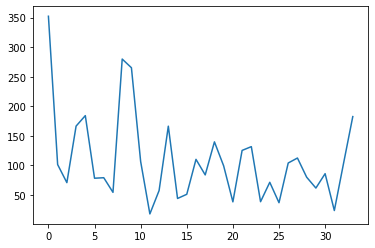

In [6]:
plt.plot(all_losses)

In [149]:
y_true_=case_catchphrases["06_102.xml"]

In [150]:
case_ids=["06_102.xml", "06_102.xml"]

In [151]:
y_true, y_pred=evaluate(case_ids, catchphrase_repr_norm)

In [152]:
y_true, y_pred

(array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0.8928391 , 0.83028626, 0.89919996, ..., 0.89919996, 0.88222003,
         0.7057195 ],
        [0.8928391 , 0.83028626, 0.89919996, ..., 0.89919996, 0.88222003,
         0.7057195 ]], dtype=float32))

In [153]:
mean_precision_k(y_true, y_pred)

0.0

In [23]:
y_pred= y_pred.detach().numpy()
NUM_CATCHPHRASES=1750
y_true=[case_catchphrases["06_102.xml"],case_catchphrases["06_102.xml"] ]

y_true=np.array([one_hot(y_true_,NUM_CATCHPHRASES ) for y_true_ in y_true])


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [97]:
k=10
p_ks = []
for y_t, y_s in zip(y_true, y_pred):
    if np.sum(y_t == 1):
        p_ks.append(precision_at_k(y_t, y_s, k=k))

In [100]:
mean_precision_k(y_true,y_pred)

0.0

In [103]:
mean_rprecision_k(y_true,y_pred)

0.0

In [104]:
mean_recall_k(y_true,y_pred)

0.0

In [102]:
mean_ndcg_score(y_true,y_pred)

0.0

In [45]:
recall_at_k(one_hot(y_true,1750),y_score)

0.0

In [47]:
average_precision_at_k(one_hot(y_true,1750),y_score)

0.0

In [49]:
ndcg_score(one_hot(y_true,1750),y_score)

0.0

In [84]:
import metrics
import importlib
importlib.reload(metrics)

<module 'metrics' from '/Users/saibo/AEPFL_S3/project/ContrastiveRetrieval/metrics.py'>

In [76]:
np.take??

In [87]:
metrics.precision_at_k()

AttributeError: module 'metrics' has no attribute 'precision_at_k'

In [52]:
def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [ ]:
for i in range(n_eval):
    case, line, case_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    predictions.append(output)

## Benchmark tranformer

Here we test the transformer via a **retrieval task**. We want to pair case **description** with the right **catchphrases** for each case in our legal dataset.

As seen preivously in the **dataset analysis**, the case description are in general very long, average length is **34k** chars,thus around **6k tokens**. However, transformer relying to squared attention only takes 512 tokens. So in this very naive baseline benchmark, we just truncate the sentence at **512th token** 

In [ ]:
# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

ds = AUSDataset()
exp_config = ExpConfig("MeanModel")
train_dataloader = ds.get_data_loader(split='train', batch_size=2, shuffle=True)
val_dataloader = ds.get_data_loader(split='val', batch_size=2, shuffle=True)
test_dataloader = ds.get_data_loader(split='test', batch_size=2, shuffle=True)

tokenizer = AutoTokenizer.from_pretrained(exp_config.uri)
encoder = AutoModel.from_pretrained(exp_config.uri) 
test_micro_contrast = 0  # running loss
test_macro_contrast = 0
nb_test_steps = 0


for step, batch in tqdm(enumerate(test_dataloader)):
    # Add batch to GPU
    "batch = tuple(t.to(device) for t in batch)"
    # Unpack the inputs from our dataloader
    sentences, catchphrases = batch  # len(sentences)=2, len(catchphrases)=2
    # Clear out the gradients (by default they accumulate)

    sentences_a, catchphrase_a = sentences[0], catchphrases[0]
    sentences_b, catchphrase_b = sentences[1], catchphrases[1]
    batch_catchphrase_a = catchphrase_a.split(EOC_TOK)
    batch_catchphrase_b = catchphrase_b.split(EOC_TOK)

    encoded_batch_catchphrase_a = tokenizer(batch_catchphrase_a, truncation=True, return_tensors="pt",
                                            padding='max_length', max_length=512)
    encoded_batch_catchphrase_b = tokenizer(batch_catchphrase_b, truncation=True, return_tensors="pt",
                                            padding='max_length', max_length=512)

    encoded_sentence_a = tokenizer(sentences_a, truncation=True, return_tensors="pt", padding='max_length',
                                   max_length=512)
    encoded_sentence_b = tokenizer(sentences_b, truncation=True, return_tensors="pt", padding='max_length',
                                   max_length=512)
    print("sentences_a length:", len(sentences_a))
    _, batch_catchphrase_embedding_a = encoder(**encoded_batch_catchphrase_a)  # [7, 768]
    _, batch_catchphrase_embedding_b = encoder(**encoded_batch_catchphrase_b)  # [13,768]

    _, sentence_embedding_a = encoder(**encoded_sentence_a)  # [1, 768]
    _, sentence_embedding_b = encoder(**encoded_sentence_b)  # [1, 768]

    left_left = torch.cdist(sentence_embedding_a, batch_catchphrase_embedding_a, p=2.0)  # [1, 768]*[7, 768]=[1, 7]
    left_right = torch.cdist(sentence_embedding_a, batch_catchphrase_embedding_b,
                             p=2.0)  # [1, 768]*[13, 768]=[1, 13]

    right_right = torch.cdist(sentence_embedding_b, batch_catchphrase_embedding_b,
                              p=2.0)  # [1, 768]*[13, 768]=[1, 13]
    right_left = torch.cdist(sentence_embedding_b, batch_catchphrase_embedding_a, p=2.0)  # [1, 768]*[7, 768]=[1, 7]

    nb_test_steps += 1
    test_macro_contrast += macro_contrast(left_left, left_right, right_right, right_left)
    test_micro_contrast += micro_contrast(left_left, left_right, right_right, right_left)

    print("Test micro contrast: {}".format(test_micro_contrast / nb_test_steps))
    print("Test macro contrast: {}".format(test_macro_contrast / nb_test_steps))

0it [00:00, ?it/s]

sentences_a length: 9849


1it [00:00,  2.46it/s]

Test micro contrast: -0.2915652096271515
Test macro contrast: -0.2915654182434082
sentences_a length: 43829


2it [00:01,  2.08it/s]

Test micro contrast: -0.15208914875984192
Test macro contrast: -0.15208923816680908
sentences_a length: 37594


3it [00:01,  1.99it/s]

Test micro contrast: -0.059666335582733154
Test macro contrast: -0.07713142782449722
sentences_a length: 16457


4it [00:02,  1.43it/s]

Test micro contrast: -0.06612031161785126
Test macro contrast: -0.060889363288879395
sentences_a length: 13591


5it [00:03,  1.58it/s]

Test micro contrast: -0.1408812701702118
Test macro contrast: -0.049582671374082565
sentences_a length: 5725


6it [00:04,  1.40it/s]

Test micro contrast: -0.16578318178653717
Test macro contrast: -0.05182870104908943
sentences_a length: 4359


7it [00:04,  1.66it/s]

Test micro contrast: -0.19738708436489105
Test macro contrast: -0.07518605142831802
sentences_a length: 28842


8it [00:04,  1.84it/s]

Test micro contrast: -0.25972646474838257
Test macro contrast: -0.10576280951499939
sentences_a length: 11473


9it [00:05,  1.96it/s]

Test micro contrast: -0.23750482499599457
Test macro contrast: -0.08275498449802399
sentences_a length: 8456


10it [00:05,  2.23it/s]

Test micro contrast: -0.19420306384563446
Test macro contrast: -0.029058266431093216
sentences_a length: 6620


11it [00:06,  2.21it/s]

Test micro contrast: -0.14246319234371185
Test macro contrast: -0.01392724271863699
sentences_a length: 31855


12it [00:06,  1.94it/s]

Test micro contrast: -0.14163948595523834
Test macro contrast: 0.004203418735414743


13it [00:07,  2.04it/s]

sentences_a length: 36872
Test micro contrast: -0.15020564198493958
Test macro contrast: 0.004489348269999027


14it [00:07,  2.04it/s]

sentences_a length: 29055
Test micro contrast: -0.15139184892177582
Test macro contrast: -0.007746492046862841
sentences_a length: 7935


15it [00:08,  1.84it/s]

Test micro contrast: -0.09898453205823898
Test macro contrast: -0.008049090392887592
sentences_a length: 76543


16it [00:09,  1.44it/s]

Test micro contrast: -0.08227216452360153
Test macro contrast: -0.012295186519622803
sentences_a length: 46535


17it [00:10,  1.48it/s]

Test micro contrast: -0.06599713116884232
Test macro contrast: -0.013866831548511982
sentences_a length: 3686


18it [00:10,  1.74it/s]

Test micro contrast: -0.022096101194620132
Test macro contrast: -0.03038530796766281


19it [00:10,  1.81it/s]

sentences_a length: 42466
Test micro contrast: -0.022785818204283714
Test macro contrast: -0.030638758093118668


20it [00:11,  2.03it/s]

sentences_a length: 14931
Test micro contrast: -0.047829221934080124
Test macro contrast: -0.03186030313372612
sentences_a length: 18023


21it [00:11,  2.03it/s]

Test micro contrast: -0.058846257627010345
Test macro contrast: -0.035361915826797485
sentences_a length: 14096


22it [00:12,  1.65it/s]

Test micro contrast: -0.05002466216683388
Test macro contrast: -0.03876715525984764
sentences_a length: 4481


23it [00:12,  1.92it/s]

Test micro contrast: -0.045403748750686646
Test macro contrast: -0.03463570028543472
sentences_a length: 12980


24it [00:13,  2.06it/s]

Test micro contrast: -0.009089861996471882
Test macro contrast: -0.03550989553332329
sentences_a length: 1951


25it [00:13,  2.10it/s]

Test micro contrast: -0.03269847482442856
Test macro contrast: -0.041228197515010834
sentences_a length: 6401


26it [00:14,  2.09it/s]

Test micro contrast: -0.03033062443137169
Test macro contrast: -0.03752788156270981
sentences_a length: 2845


27it [00:14,  2.48it/s]

Test micro contrast: -0.055818770080804825
Test macro contrast: -0.04925359785556793
sentences_a length: 30020


28it [00:15,  2.05it/s]

Test micro contrast: -0.052247993648052216
Test macro contrast: -0.04458241909742355
sentences_a length: 39861


29it [00:16,  1.51it/s]

Test micro contrast: -0.04358787089586258
Test macro contrast: -0.04476936161518097
sentences_a length: 9912


30it [00:16,  1.78it/s]

Test micro contrast: -0.02267518825829029
Test macro contrast: -0.01812257058918476


31it [00:16,  1.92it/s]

sentences_a length: 5403
Test micro contrast: -0.021871112287044525
Test macro contrast: -0.026183927431702614
sentences_a length: 25180


32it [00:17,  1.67it/s]

Test micro contrast: -0.04150398448109627
Test macro contrast: -0.029904872179031372
sentences_a length: 31675


33it [00:18,  1.37it/s]

Test micro contrast: -0.08122880756855011
Test macro contrast: -0.03610634803771973
sentences_a length: 28761


34it [00:19,  1.42it/s]

Test micro contrast: -0.08646271377801895
Test macro contrast: -0.042667388916015625
sentences_a length: 51217


35it [00:20,  1.23it/s]

Test micro contrast: -0.08477326482534409
Test macro contrast: -0.04952338710427284


36it [00:21,  1.37it/s]

sentences_a length: 7098
Test micro contrast: -0.09187286347150803
Test macro contrast: -0.053943634033203125


37it [00:21,  1.51it/s]

sentences_a length: 8538
Test micro contrast: -0.08995797485113144
Test macro contrast: -0.054261624813079834


38it [00:21,  1.76it/s]

sentences_a length: 12820
Test micro contrast: -0.08996535837650299
Test macro contrast: -0.05359787121415138
sentences_a length: 20795


39it [00:22,  1.60it/s]

Test micro contrast: -0.08718250691890717
Test macro contrast: -0.05174751952290535


40it [00:23,  1.47it/s]

sentences_a length: 66738
Test micro contrast: -0.0874921903014183
Test macro contrast: -0.05294307321310043
sentences_a length: 57633


41it [00:24,  1.26it/s]

Test micro contrast: -0.08664834499359131
Test macro contrast: -0.05376070365309715
sentences_a length: 24273


42it [00:25,  1.38it/s]

Test micro contrast: -0.08495472371578217
Test macro contrast: -0.05285012722015381
sentences_a length: 24988


43it [00:25,  1.64it/s]

Test micro contrast: -0.10063589364290237
Test macro contrast: -0.05217268690466881
sentences_a length: 39933


44it [00:26,  1.66it/s]

Test micro contrast: -0.09374707192182541
Test macro contrast: -0.050816938281059265
sentences_a length: 3738


45it [00:26,  1.92it/s]

Test micro contrast: -0.09634701162576675
Test macro contrast: -0.05354951694607735
sentences_a length: 18375


46it [00:26,  1.83it/s]

Test micro contrast: -0.10679062455892563
Test macro contrast: -0.05282467231154442


47it [00:27,  1.86it/s]

sentences_a length: 9564
Test micro contrast: -0.11388696730136871
Test macro contrast: -0.061069224029779434
sentences_a length: 4147


48it [00:28,  1.50it/s]

Test micro contrast: -0.1165132224559784
Test macro contrast: -0.06158343330025673
sentences_a length: 18508


49it [00:29,  1.49it/s]

Test micro contrast: -0.1248675286769867
Test macro contrast: -0.0673394501209259
sentences_a length: 1028


50it [00:29,  1.47it/s]

Test micro contrast: -0.08492667227983475
Test macro contrast: -0.06336750090122223
sentences_a length: 41055


51it [00:31,  1.15it/s]

Test micro contrast: -0.08275644481182098
Test macro contrast: -0.06206556037068367
sentences_a length: 48924


52it [00:31,  1.19it/s]

Test micro contrast: -0.07971576601266861
Test macro contrast: -0.06414929032325745


53it [00:32,  1.41it/s]

sentences_a length: 29804
Test micro contrast: -0.07617688924074173
Test macro contrast: -0.06090410798788071
sentences_a length: 34544


54it [00:32,  1.46it/s]

Test micro contrast: -0.07111556828022003
Test macro contrast: -0.05955566465854645
sentences_a length: 16492


55it [00:33,  1.30it/s]

Test micro contrast: -0.0747065320611
Test macro contrast: -0.061950623989105225
sentences_a length: 4961


56it [00:34,  1.50it/s]

Test micro contrast: -0.0666022077202797
Test macro contrast: -0.06038342043757439
sentences_a length: 9619


57it [00:34,  1.70it/s]

Test micro contrast: -0.09173166006803513
Test macro contrast: -0.06360092014074326
sentences_a length: 14358


58it [00:35,  1.89it/s]

Test micro contrast: -0.09134522080421448
Test macro contrast: -0.06476467847824097
sentences_a length: 7946


59it [00:35,  1.61it/s]

Test micro contrast: -0.09457195550203323
Test macro contrast: -0.06705283373594284
sentences_a length: 7102


60it [00:36,  1.77it/s]

Test micro contrast: -0.09365064650774002
Test macro contrast: -0.06859808415174484
sentences_a length: 7328


61it [00:36,  2.08it/s]

Test micro contrast: -0.0991426482796669
Test macro contrast: -0.0725482702255249
sentences_a length: 8596


62it [00:37,  2.25it/s]

Test micro contrast: -0.10159669816493988
Test macro contrast: -0.07312946021556854
sentences_a length: 6493


63it [00:38,  1.48it/s]

Test micro contrast: -0.10560236871242523
Test macro contrast: -0.07332772761583328
sentences_a length: 16077


64it [00:38,  1.63it/s]

Test micro contrast: -0.10659968107938766
Test macro contrast: -0.07294259965419769
sentences_a length: 14898


65it [00:39,  1.90it/s]

Test micro contrast: -0.10746711492538452
Test macro contrast: -0.07432783395051956
sentences_a length: 3798


66it [00:40,  1.40it/s]

Test micro contrast: -0.1094883382320404
Test macro contrast: -0.07412353903055191
sentences_a length: 11647


67it [00:40,  1.42it/s]

Test micro contrast: -0.08876711130142212
Test macro contrast: -0.0775754526257515
sentences_a length: 8726


68it [00:41,  1.44it/s]

Test micro contrast: -0.09003031253814697
Test macro contrast: -0.0772327110171318
sentences_a length: 52237


69it [00:42,  1.40it/s]

Test micro contrast: -0.0878654271364212
Test macro contrast: -0.0777420774102211
sentences_a length: 4497


70it [00:43,  1.23it/s]

Test micro contrast: -0.09790365397930145
Test macro contrast: -0.0784536600112915
sentences_a length: 10040


71it [00:44,  1.21it/s]

Test micro contrast: -0.09848601371049881
Test macro contrast: -0.07802968472242355
sentences_a length: 25666


72it [00:44,  1.23it/s]

Test micro contrast: -0.08629627525806427
Test macro contrast: -0.07949912548065186
sentences_a length: 9120


73it [00:45,  1.35it/s]

Test micro contrast: -0.07967273145914078
Test macro contrast: -0.0787789449095726
sentences_a length: 6645


74it [00:45,  1.55it/s]

Test micro contrast: -0.0798962339758873
Test macro contrast: -0.07739415019750595
sentences_a length: 16558


75it [00:46,  1.61it/s]

Test micro contrast: -0.08164047449827194
Test macro contrast: -0.07552285492420197
sentences_a length: 4290


76it [00:47,  1.66it/s]

Test micro contrast: -0.08630166202783585
Test macro contrast: -0.07710706442594528
sentences_a length: 24349


77it [00:47,  1.80it/s]

Test micro contrast: -0.08636971563100815
Test macro contrast: -0.07813010364770889
sentences_a length: 62731


78it [00:48,  1.56it/s]

Test micro contrast: -0.0817670226097107
Test macro contrast: -0.07782872766256332
sentences_a length: 34654


79it [00:48,  1.65it/s]

Test micro contrast: -0.10452708601951599
Test macro contrast: -0.07818122208118439
sentences_a length: 7999


80it [00:49,  1.81it/s]

Test micro contrast: -0.09899888932704926
Test macro contrast: -0.07875292748212814


81it [00:49,  1.79it/s]

sentences_a length: 6986
Test micro contrast: -0.10573559999465942
Test macro contrast: -0.07637592405080795
sentences_a length: 8008


82it [00:50,  2.08it/s]

Test micro contrast: -0.10559378564357758
Test macro contrast: -0.07729228585958481
sentences_a length: 29728


83it [00:50,  1.96it/s]

Test micro contrast: -0.09599396586418152
Test macro contrast: -0.0702342763543129
sentences_a length: 25881


84it [00:51,  1.56it/s]

Test micro contrast: -0.09613732248544693
Test macro contrast: -0.07026087492704391
sentences_a length: 20123


85it [00:52,  1.70it/s]

Test micro contrast: -0.09388694167137146
Test macro contrast: -0.06981449574232101
sentences_a length: 30282


86it [00:53,  1.44it/s]

Test micro contrast: -0.09265435487031937
Test macro contrast: -0.07000884413719177
sentences_a length: 49385


87it [00:54,  1.18it/s]

Test micro contrast: -0.09465117007493973
Test macro contrast: -0.0717281773686409
sentences_a length: 19927


88it [00:55,  1.20it/s]

Test micro contrast: -0.10307541489601135
Test macro contrast: -0.07116243988275528
sentences_a length: 7480


89it [00:55,  1.47it/s]

Test micro contrast: -0.10246115922927856
Test macro contrast: -0.07229117304086685
sentences_a length: 7512


90it [00:55,  1.60it/s]

Test micro contrast: -0.10554265975952148
Test macro contrast: -0.07057129591703415
sentences_a length: 10505


91it [00:56,  1.65it/s]

Test micro contrast: -0.10367537289857864
Test macro contrast: -0.06860993802547455
sentences_a length: 12361


92it [00:57,  1.76it/s]

Test micro contrast: -0.10332786291837692
Test macro contrast: -0.06905641406774521
sentences_a length: 13231


93it [00:57,  1.77it/s]

Test micro contrast: -0.11241645365953445
Test macro contrast: -0.07102367281913757
sentences_a length: 3300


94it [00:58,  1.83it/s]

Test micro contrast: -0.11087185144424438
Test macro contrast: -0.07010876387357712
sentences_a length: 22887


95it [00:58,  1.73it/s]

Test micro contrast: -0.10991932451725006
Test macro contrast: -0.0702228918671608
sentences_a length: 49918


96it [00:59,  1.58it/s]

Test micro contrast: -0.10895314067602158
Test macro contrast: -0.06967020779848099
sentences_a length: 18918


97it [01:00,  1.68it/s]

Test micro contrast: -0.10135995596647263
Test macro contrast: -0.0675693079829216
sentences_a length: 42223


98it [01:00,  1.58it/s]

Test micro contrast: -0.10721321403980255
Test macro contrast: -0.06868034601211548
sentences_a length: 8081


99it [01:00,  1.94it/s]

Test micro contrast: -0.10793555527925491
Test macro contrast: -0.06909677386283875
sentences_a length: 25109


100it [01:01,  2.04it/s]

Test micro contrast: -0.11433444917201996
Test macro contrast: -0.06613782048225403
sentences_a length: 6994


101it [01:01,  2.04it/s]

Test micro contrast: -0.11418984830379486
Test macro contrast: -0.06548433750867844
sentences_a length: 33942
Test micro contrast: -0.11258488148450851


102it [01:02,  1.81it/s]

Test macro contrast: -0.06577669084072113


103it [01:03,  1.47it/s]

sentences_a length: 66030
Test micro contrast: -0.11546555906534195
Test macro contrast: -0.06676119565963745
sentences_a length: 16272


104it [01:04,  1.44it/s]

Test micro contrast: -0.11555671691894531
Test macro contrast: -0.06693897396326065
sentences_a length: 13671


105it [01:04,  1.75it/s]

Test micro contrast: -0.1156507134437561
Test macro contrast: -0.06681861728429794
sentences_a length: 27637


106it [01:05,  1.50it/s]

Test micro contrast: -0.10236270725727081
Test macro contrast: -0.06563343107700348
sentences_a length: 9221


107it [01:06,  1.57it/s]

Test micro contrast: -0.10057570785284042
Test macro contrast: -0.06504914164543152
sentences_a length: 9681


108it [01:06,  1.79it/s]

Test micro contrast: -0.1070118099451065
Test macro contrast: -0.0636371597647667
sentences_a length: 14718


109it [01:07,  1.65it/s]

Test micro contrast: -0.12113679945468903
Test macro contrast: -0.06538040935993195
sentences_a length: 3324


110it [01:07,  1.57it/s]

Test micro contrast: -0.1104222759604454
Test macro contrast: -0.0662970319390297
sentences_a length: 4165


111it [01:08,  1.75it/s]

Test micro contrast: -0.10872430354356766
Test macro contrast: -0.06502936035394669
sentences_a length: 25851


112it [01:09,  1.50it/s]

Test micro contrast: -0.11066184937953949
Test macro contrast: -0.06639426201581955
sentences_a length: 48551


113it [01:10,  1.35it/s]

Test micro contrast: -0.11855035275220871
Test macro contrast: -0.06969314068555832
sentences_a length: 27856


114it [01:10,  1.49it/s]

Test micro contrast: -0.11644253879785538
Test macro contrast: -0.06597577780485153
sentences_a length: 5203


115it [01:11,  1.49it/s]

Test micro contrast: -0.115366131067276
Test macro contrast: -0.06409580260515213
sentences_a length: 55284


116it [01:12,  1.23it/s]

Test micro contrast: -0.10960303246974945
Test macro contrast: -0.06438794732093811
sentences_a length: 16712


117it [01:13,  1.24it/s]

Test micro contrast: -0.1114208772778511
Test macro contrast: -0.06588244438171387
sentences_a length: 19849


118it [01:13,  1.41it/s]

Test micro contrast: -0.11318126320838928
Test macro contrast: -0.0671706274151802
sentences_a length: 3843


119it [01:14,  1.54it/s]

Test micro contrast: -0.11695852130651474
Test macro contrast: -0.06766831874847412
sentences_a length: 8219


120it [01:15,  1.31it/s]

Test micro contrast: -0.1165732815861702
Test macro contrast: -0.06776262074708939
sentences_a length: 33805


121it [01:15,  1.36it/s]

Test micro contrast: -0.11959771811962128
Test macro contrast: -0.07036682963371277
sentences_a length: 8955


122it [01:16,  1.54it/s]

Test micro contrast: -0.12051709741353989
Test macro contrast: -0.0734056904911995
sentences_a length: 26265


123it [01:17,  1.44it/s]

Test micro contrast: -0.11895917356014252
Test macro contrast: -0.0724334716796875
sentences_a length: 17262


124it [01:17,  1.60it/s]

Test micro contrast: -0.12142619490623474
Test macro contrast: -0.07470331341028214
sentences_a length: 28095


125it [01:18,  1.52it/s]

Test micro contrast: -0.1220051720738411
Test macro contrast: -0.07596590369939804
sentences_a length: 5138


126it [01:19,  1.49it/s]

Test micro contrast: -0.1215498223900795
Test macro contrast: -0.07652760297060013
sentences_a length: 33780


127it [01:25,  2.36s/it]

Test micro contrast: -0.121297188103199
Test macro contrast: -0.07638566941022873
sentences_a length: 34246


128it [01:26,  1.89s/it]

Test micro contrast: -0.11722979694604874
Test macro contrast: -0.07640977203845978
sentences_a length: 6879


129it [01:26,  1.41s/it]

Test micro contrast: -0.11741777509450912
Test macro contrast: -0.07423307001590729
sentences_a length: 8301


130it [01:26,  1.10s/it]

Test micro contrast: -0.11407721042633057
Test macro contrast: -0.0764470249414444
sentences_a length: 18782


131it [01:27,  1.08it/s]

Test micro contrast: -0.11593083292245865
Test macro contrast: -0.07909170538187027
sentences_a length: 38665


132it [01:28,  1.06s/it]

Test micro contrast: -0.11300309002399445
Test macro contrast: -0.07897688448429108
sentences_a length: 11450


133it [01:29,  1.13it/s]

Test micro contrast: -0.11153977364301682
Test macro contrast: -0.08068326860666275
sentences_a length: 49874


134it [01:30,  1.08it/s]

Test micro contrast: -0.1119474545121193
Test macro contrast: -0.0821710005402565


135it [01:30,  1.32it/s]

sentences_a length: 30596
Test micro contrast: -0.11274603754281998
Test macro contrast: -0.08319015055894852
sentences_a length: 15751


136it [01:31,  1.46it/s]

Test micro contrast: -0.1141093373298645
Test macro contrast: -0.08347848802804947
sentences_a length: 43072


137it [01:31,  1.33it/s]

Test micro contrast: -0.11311952024698257
Test macro contrast: -0.08271225541830063
sentences_a length: 22614


138it [01:33,  1.10it/s]

Test micro contrast: -0.11347213387489319
Test macro contrast: -0.08248186856508255
sentences_a length: 16158


139it [01:33,  1.21it/s]

Test micro contrast: -0.11296045035123825
Test macro contrast: -0.08183258026838303
sentences_a length: 14286


140it [01:34,  1.45it/s]

Test micro contrast: -0.11331024020910263
Test macro contrast: -0.08150547742843628
sentences_a length: 16360


141it [01:35,  1.39it/s]

Test micro contrast: -0.11585424840450287
Test macro contrast: -0.07819641381502151
sentences_a length: 6635


142it [01:35,  1.71it/s]

Test micro contrast: -0.11586862057447433
Test macro contrast: -0.07847598195075989
sentences_a length: 13230


143it [01:36,  1.54it/s]

Test micro contrast: -0.12027681618928909
Test macro contrast: -0.08314567059278488


144it [01:36,  1.61it/s]

sentences_a length: 14046
Test micro contrast: -0.11964760720729828
Test macro contrast: -0.08277431130409241
sentences_a length: 38394


145it [01:37,  1.53it/s]

Test micro contrast: -0.11898774653673172
Test macro contrast: -0.08201815187931061
sentences_a length: 4135


146it [01:38,  1.35it/s]

Test micro contrast: -0.11029914766550064
Test macro contrast: -0.0804554894566536
sentences_a length: 6101


147it [01:38,  1.48it/s]

Test micro contrast: -0.10852514952421188
Test macro contrast: -0.08059290051460266


148it [01:39,  1.70it/s]

sentences_a length: 32584
Test micro contrast: -0.1125762015581131
Test macro contrast: -0.08167403191328049
sentences_a length: 72910


149it [01:40,  1.38it/s]

Test micro contrast: -0.11333458125591278
Test macro contrast: -0.08246587216854095
sentences_a length: 14555


In [3]:


# def train_contrast_retrieval(data_config, exp_config):


# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

ds = AUSDataset()
train_dataloader = ds.get_data_loader(split='train', batch_size=2, shuffle=True)
val_dataloader = ds.get_data_loader(split='val', batch_size=2, shuffle=True)
test_dataloader = ds.get_data_loader(split='test', batch_size=2, shuffle=True)

tokenizer = AutoTokenizer.from_pretrained(exp_config.uri)
encoder = AutoModel.from_pretrained(exp_config.uri)

model = NNModel(exp_config)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
# print(encoder.parameters())

# for name, param in encoder.named_parameters():
#     print(name, param.size())
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = exp_config.epochs

# trange is a tqdm wrapper around the normal python range
for epoch__ in trange(epochs, desc="Epoch"):

    print("start training")

    # Set our model to training mode (as opposed to evaluation mode)
    encoder.train()

    # Tracking variables
    tr_loss = 0  # running loss
    nb_tr_steps = 0

    # Train the data for one epoch
    for step, batch in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        # Unpack the inputs from our dataloader
        sentences, catchphrases = batch  # len(sentences)=2, len(catchphrases)=2
        # Clear out the gradients (by default they accumulate)

        sentences_a, catchphrase_a = sentences[0], catchphrases[0]
        sentences_b, catchphrase_b = sentences[1], catchphrases[1]

        batch_catchphrase_a = catchphrase_a.split(EOC_TOK)
        batch_catchphrase_b = catchphrase_b.split(EOC_TOK)

        encoded_batch_catchphrase_a = tokenizer(batch_catchphrase_a, truncation=True, return_tensors="pt",
                                                padding='max_length', max_length=128)
        encoded_batch_catchphrase_b = tokenizer(batch_catchphrase_b, truncation=True, return_tensors="pt",
                                                padding='max_length', max_length=128)

        sentence_indices_a = tokenizer(sentences_a, truncation=True, return_tensors="pt", padding='max_length',
                                       max_length=512*12)
        sentence_indices_b = tokenizer(sentences_b, truncation=True, return_tensors="pt", padding='max_length',
                                       max_length=512*12)

        _, batch_catchphrase_embedding_a = encoder(**encoded_batch_catchphrase_a)  # [7, 768]
        _, batch_catchphrase_embedding_b = encoder(**encoded_batch_catchphrase_b)  # [13,768]

        
        chunk_indices_a=chunkify(sentence_indices_a)
        
        chunk_indices_b=chunkify(sentence_indices_b)
         

        chunk_embeddings_a=encode_chunks(chunk_indices_a,encoder)
        chunk_embeddings_b=encode_chunks(chunk_indices_b,encoder)
    
        
        #################### Aggregation ######################
        sentence_embedding_a=torch.mean(chunk_embeddings_a,dim=0)
        sentence_embedding_b=torch.mean(chunk_embeddings_b,dim=0)
        

        triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

        anchor_a = sentence_embedding_a.unsqueeze(0)
        anchor_b = sentence_embedding_b.unsqueeze(0)
        batch_train_loss_set=[]
        for catchphrase_embedding_a in tqdm(batch_catchphrase_embedding_a):
            for catchphrase_embedding_b in batch_catchphrase_embedding_b:
                positive = catchphrase_embedding_a.unsqueeze(0)
                negative = catchphrase_embedding_b.unsqueeze(0)
                loss = triplet_loss(anchor_a, positive, negative)
                batch_train_loss_set.append(loss.unsqueeze(0))
                loss = triplet_loss(anchor_b, negative, positive)
                batch_train_loss_set.append(loss.unsqueeze(0))
        batch_loss=torch.mean(torch.cat(batch_train_loss_set))
        batch_loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += batch_loss.item()
        nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss/nb_tr_steps))





Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<generator object Module.parameters at 0x11ead27d0>
embeddings.word_embeddings.weight torch.Size([30522, 128])
embeddings.position_embeddings.weight torch.Size([512, 128])
embeddings.token_type_embeddings.weight torch.Size([2, 128])
embeddings.LayerNorm.weight torch.Size([128])
embeddings.LayerNorm.bias torch.Size([128])
encoder.layer.0.attention.self.query.weight torch.Size([128, 128])
encoder.layer.0.attention.self.query.bias torch.Size([128])
encoder.layer.0.attention.self.key.weight torch.Size([128, 128])
encoder.layer.0.attention.self.key.bias torch.Size([128])
encoder.layer.0.attention.self.value.weight torch.Size([128, 128])
encoder.layer.0.attention.self.value.bias torch.Size([128])
encoder.layer.0.attention.output.dense.weight torch.Size([128, 128])
encoder.layer.0.attention.output.dense.bias torch.Size([128])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([128])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([128])
encoder.layer.0.intermediate.dense.


0it [00:00, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 419.23it/s]

1it [00:01,  1.93s/it]

Train loss: 0.9539670348167419




100%|██████████| 3/3 [00:00<00:00, 1381.22it/s]

2it [00:03,  1.84s/it]

Train loss: 0.9075373709201813




100%|██████████| 8/8 [00:00<00:00, 977.12it/s]

3it [00:05,  1.80s/it]

Train loss: 1.1290541291236877




100%|██████████| 9/9 [00:00<00:00, 738.07it/s]

4it [00:07,  1.83s/it]

Train loss: 1.256189987063408




100%|██████████| 8/8 [00:00<00:00, 1122.63it/s]

5it [00:08,  1.79s/it]

Train loss: 1.1780067563056946




100%|██████████| 4/4 [00:00<00:00, 618.06it/s]

6it [00:10,  1.75s/it]

Train loss: 1.146119753519694




100%|██████████| 6/6 [00:00<00:00, 2272.72it/s]

7it [00:12,  1.72s/it]

Train loss: 1.1346594946725028




100%|██████████| 9/9 [00:00<00:00, 334.79it/s]

8it [00:14,  1.87s/it]

Train loss: 1.124840572476387




100%|██████████| 16/16 [00:00<00:00, 1346.57it/s]

9it [00:16,  2.01s/it]

Train loss: 1.1646321217219036




100%|██████████| 9/9 [00:00<00:00, 1404.55it/s]

10it [00:18,  1.95s/it]

Train loss: 1.1421508550643922




100%|██████████| 2/2 [00:00<00:00, 943.81it/s]

11it [00:20,  1.86s/it]

Train loss: 1.128929316997528




100%|██████████| 4/4 [00:00<00:00, 673.86it/s]

12it [00:21,  1.83s/it]

Train loss: 1.1101349145174026




100%|██████████| 8/8 [00:00<00:00, 793.08it/s]

13it [00:23,  1.82s/it]

Train loss: 1.097806637103741




100%|██████████| 7/7 [00:00<00:00, 805.07it/s]

14it [00:25,  1.80s/it]

Train loss: 1.0909655775342668




100%|██████████| 5/5 [00:00<00:00, 283.03it/s]

15it [00:27,  1.84s/it]

Train loss: 1.0879690329233804




100%|██████████| 3/3 [00:00<00:00, 1232.53it/s]

16it [00:29,  1.77s/it]

Train loss: 1.0805836729705334




100%|██████████| 5/5 [00:00<00:00, 2139.51it/s]

17it [00:30,  1.74s/it]

Train loss: 1.0767362994306229




100%|██████████| 10/10 [00:00<00:00, 882.70it/s]

18it [00:32,  1.73s/it]

Train loss: 1.072382089164522




100%|██████████| 7/7 [00:00<00:00, 1602.89it/s]

19it [00:34,  1.73s/it]

Train loss: 1.0712848493927403




100%|██████████| 5/5 [00:00<00:00, 743.28it/s]

20it [00:35,  1.73s/it]

Train loss: 1.0669104963541032




100%|██████████| 7/7 [00:00<00:00, 1335.58it/s]

21it [00:37,  1.73s/it]

Train loss: 1.0615287905647641




100%|██████████| 5/5 [00:00<00:00, 1008.49it/s]

22it [00:39,  1.81s/it]

Train loss: 1.0627357092770664




100%|██████████| 5/5 [00:00<00:00, 814.30it/s]

23it [00:41,  1.79s/it]

Train loss: 1.0599717601485874




100%|██████████| 7/7 [00:00<00:00, 1444.46it/s]

24it [00:43,  1.81s/it]

Train loss: 1.058027721941471




100%|██████████| 7/7 [00:00<00:00, 802.85it/s]

25it [00:45,  1.93s/it]

Train loss: 1.0584177803993224




100%|██████████| 5/5 [00:00<00:00, 748.64it/s]

26it [00:47,  1.89s/it]

Train loss: 1.0560370293947368




100%|██████████| 7/7 [00:00<00:00, 489.82it/s]

27it [00:49,  1.86s/it]

Train loss: 1.054437679273111




100%|██████████| 16/16 [00:00<00:00, 930.66it/s]

28it [00:50,  1.87s/it]

Train loss: 1.0534850720848357




100%|██████████| 8/8 [00:00<00:00, 1014.74it/s]

29it [00:52,  1.86s/it]

Train loss: 1.051804947442022




100%|██████████| 4/4 [00:00<00:00, 349.07it/s]

30it [00:55,  2.01s/it]

Train loss: 1.0502635776996612




100%|██████████| 6/6 [00:00<00:00, 599.34it/s]

31it [00:56,  1.94s/it]

Train loss: 1.0492189911104017




100%|██████████| 3/3 [00:00<00:00, 946.44it/s]

32it [00:58,  1.93s/it]

Train loss: 1.0475201085209846




100%|██████████| 5/5 [00:00<00:00, 394.51it/s]

33it [01:00,  1.91s/it]

Train loss: 1.0464765339186697




100%|██████████| 14/14 [00:00<00:00, 1013.10it/s]

34it [01:02,  1.96s/it]

Train loss: 1.0449990279534285




100%|██████████| 2/2 [00:00<00:00, 1473.75it/s]

35it [01:04,  1.85s/it]

Train loss: 1.0440946340560913




100%|██████████| 7/7 [00:00<00:00, 799.94it/s]

36it [01:06,  1.84s/it]

Train loss: 1.0426333546638489




100%|██████████| 6/6 [00:00<00:00, 500.50it/s]

37it [01:07,  1.83s/it]

Train loss: 1.041484790879327




100%|██████████| 11/11 [00:00<00:00, 1343.47it/s]

38it [01:10,  1.91s/it]

Train loss: 1.0403339894194352




100%|██████████| 9/9 [00:00<00:00, 813.76it/s]

39it [01:11,  1.88s/it]

Train loss: 1.039344127361591




100%|██████████| 4/4 [00:00<00:00, 317.14it/s]

40it [01:13,  1.91s/it]

Train loss: 1.0383957266807555




100%|██████████| 9/9 [00:00<00:00, 562.78it/s]

41it [01:16,  2.01s/it]

Train loss: 1.0373242730047645




100%|██████████| 3/3 [00:00<00:00, 448.24it/s]

42it [01:18,  1.99s/it]

Train loss: 1.0365815545831407




100%|██████████| 3/3 [00:00<00:00, 830.12it/s]

43it [01:20,  2.01s/it]

Train loss: 1.034249911474627




100%|██████████| 6/6 [00:00<00:00, 768.94it/s]

44it [01:21,  1.90s/it]

Train loss: 1.033472474325787




100%|██████████| 6/6 [00:00<00:00, 468.64it/s]

45it [01:23,  1.95s/it]

Train loss: 1.0330443369017708




100%|██████████| 8/8 [00:00<00:00, 481.72it/s]

46it [01:25,  2.03s/it]

Train loss: 1.032287006792815




100%|██████████| 6/6 [00:00<00:00, 672.92it/s]

47it [01:27,  1.97s/it]

Train loss: 1.0307795823888575




100%|██████████| 6/6 [00:00<00:00, 982.92it/s]

48it [01:29,  1.95s/it]

Train loss: 1.0300911230345566




100%|██████████| 12/12 [00:00<00:00, 507.64it/s]

49it [01:31,  1.98s/it]

Train loss: 1.0303238861414852




100%|██████████| 19/19 [00:00<00:00, 627.47it/s]

50it [01:33,  2.03s/it]

Train loss: 1.028086905479431




100%|██████████| 2/2 [00:00<00:00, 534.92it/s]

51it [01:35,  1.92s/it]

Train loss: 1.0282884368709488




100%|██████████| 6/6 [00:00<00:00, 715.73it/s]

52it [01:37,  1.89s/it]

Train loss: 1.0263760766157737




100%|██████████| 6/6 [00:00<00:00, 1386.01it/s]

53it [01:39,  1.82s/it]

Train loss: 1.0253380267125256




100%|██████████| 3/3 [00:00<00:00, 887.56it/s]

54it [01:40,  1.76s/it]

Train loss: 1.0249824877138491




100%|██████████| 4/4 [00:00<00:00, 658.14it/s]

55it [01:42,  1.74s/it]

Train loss: 1.0258116006851197




100%|██████████| 7/7 [00:00<00:00, 849.49it/s]

56it [01:44,  1.78s/it]

Train loss: 1.022093957023961




100%|██████████| 3/3 [00:00<00:00, 645.44it/s]

57it [01:46,  1.87s/it]

Train loss: 1.0187447740320574




100%|██████████| 4/4 [00:00<00:00, 401.45it/s]

58it [01:48,  1.98s/it]

Train loss: 1.0190570786081512




100%|██████████| 8/8 [00:00<00:00, 1134.25it/s]
58it [01:50,  1.91s/it]
Epoch:   0%|          | 0/10 [01:50<?, ?it/s]


KeyboardInterrupt: 

In [2]:
if __name__ == '__main__':
    ds = AUSDataset()

    # ds.save_processed_splits()

    test_dataloader = ds.get_data_loader(split='test', batch_size=2, shuffle=True)
    # print(test_dl.batch_size)
    # for i in test_dl:
    #     print(len(i[0]),len(i[1]))
    data_config = DatasetConfig("AUS")
    exp_config = ExpConfig("MeanModel")
    train_contrast_retrieval(data_config, exp_config)

NameError: name 'train_contrast_retrieval' is not defined